# Seq2Seq (Sequence-to-Sequence)

### Embedding Vector

1. 영어 Glove 임베딩 (사전 학습) 사용 / 6B tokens, 400K vocab, uncased, 100d
2. 한국어 임베딩 (초기 훈련)

In [1]:
!gdown 1qk-14tgVHPXT5jfRUE4Ua2ji4EXwS022

Downloading...
From (original): https://drive.google.com/uc?id=1qk-14tgVHPXT5jfRUE4Ua2ji4EXwS022
From (redirected): https://drive.google.com/uc?id=1qk-14tgVHPXT5jfRUE4Ua2ji4EXwS022&confirm=t&uuid=614dda06-a05a-4793-9395-50dc1fe0a847
To: c:\Users\Playdata\nlp\07_seq2seq\glove.6B.100d.txt

  0%|          | 0.00/347M [00:00<?, ?B/s]
  0%|          | 524k/347M [00:00<02:10, 2.66MB/s]
  1%|          | 2.10M/347M [00:00<00:47, 7.30MB/s]
  1%|▏         | 4.72M/347M [00:00<00:26, 13.0MB/s]
  3%|▎         | 10.5M/347M [00:00<00:12, 26.9MB/s]
  4%|▍         | 14.7M/347M [00:00<00:15, 21.1MB/s]
  5%|▌         | 18.9M/347M [00:01<00:16, 20.4MB/s]
  7%|▋         | 25.7M/347M [00:01<00:11, 28.8MB/s]
  9%|▉         | 30.4M/347M [00:01<00:10, 29.4MB/s]
 10%|▉         | 34.1M/347M [00:01<00:10, 29.3MB/s]
 11%|█         | 37.7M/347M [00:01<00:10, 28.2MB/s]
 12%|█▏        | 40.9M/347M [00:01<00:12, 25.1MB/s]
 13%|█▎        | 44.6M/347M [00:01<00:11, 26.6MB/s]
 14%|█▎        | 47.7M/347M [00:02<00:12, 23.

### 학습 데이터 준비

http://www.manythings.org/anki/

1. Encoder 입력 데이터 eng
    - encoder_input_eng 준비 `I love you`
2. Decoder 출력 데이터 kor
    - 학습용 teacher-forcing 모델
        - decoder_input_kor `<sos> 난 널 사랑해`
        - docoder_output_kor `난 널 사랑해 <eos>`
    - 추론용 모델

In [2]:
!gdown 17-luLRrDsnP_yIzIchd3aCo_WMt4znPF -O eng_kor.txt

Downloading...
From: https://drive.google.com/uc?id=17-luLRrDsnP_yIzIchd3aCo_WMt4znPF
To: c:\Users\Playdata\nlp\07_seq2seq\eng_kor.txt

  0%|          | 0.00/864k [00:00<?, ?B/s]
 61%|██████    | 524k/864k [00:00<00:00, 2.43MB/s]
100%|██████████| 864k/864k [00:00<00:00, 3.50MB/s]


In [3]:
eng_inputs = []    # 영어 원문 문장 리스트
kor_inputs = []    # 한국어 입력(디코더 입력) 리스트
kor_targets = []   # 한국어 타겟(정답) 리스트

with open('eng_kor.txt', 'r', encoding='utf-8') as f:
    for line in f:                        # 파일을 한 줄씩 순회
        eng, kor, _ = line.split('\t')    # "영어\t한국어\t(기타)" 형태로 분리

        kor_input = '<sos> ' + kor         # 디코더 입력 : 시작 토큰 추가
        kor_target = kor + ' <eos>'        # 디코더 타겟 : 종료 토큰 추가

        eng_inputs.append(eng)            # 영어 문장
        kor_inputs.append(kor_input)      # 한국어 입력 시퀀스
        kor_targets.append(kor_target)    # 한국어 타겟 시퀀스

len(eng_inputs), len(kor_inputs), len(kor_targets)

(5890, 5890, 5890)

In [4]:
print(eng_inputs[2500:2505])
print(kor_inputs[2500:2505])   # <sos> 토큰 포함
print(kor_targets[2500:2505])  # <eos> 토큰 포함

['I speak French a little.', 'I take back what I said.', 'I tried to make friends.', 'I use this all the time.', 'I use this all the time.']
['<sos> 저는 프랑스어를 조금 합니다.', '<sos> 아까 한 말 취소야.', '<sos> 난 친구를 만드려고 했어.', '<sos> 나는 항상 이걸 쓴다.', '<sos> 매번 이걸 쓴다.']
['저는 프랑스어를 조금 합니다. <eos>', '아까 한 말 취소야. <eos>', '난 친구를 만드려고 했어. <eos>', '나는 항상 이걸 쓴다. <eos>', '매번 이걸 쓴다. <eos>']


### 토큰화
- 인코더(영어) : 영문 토크나이저
- 디코더(한글) : 국문 토크나이저

In [5]:
VOCAB_SIZE = 10000  # 사용할 최대 어휘 수(상위 빈도 단어 기준)

##### 영문 토큰화

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

eng_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')  # 어휘 제한 + 미등록 단어를 <OOV>로 처리
eng_tokenizer.fit_on_texts(eng_inputs)                              # 영어 문장들로 단어 사전(word_index) 학습
eng_inputs_seq = eng_tokenizer.texts_to_sequences(eng_inputs)       # 영어 문장 -> 단어 ID 시퀀스로 변환

print(eng_inputs[2500:2505])
eng_inputs_seq[2500:2505]

['I speak French a little.', 'I take back what I said.', 'I tried to make friends.', 'I use this all the time.', 'I use this all the time.']


[[2, 130, 38, 8, 268],
 [2, 111, 150, 27, 2, 82],
 [2, 300, 4, 213, 202],
 [2, 206, 12, 54, 6, 60],
 [2, 206, 12, 54, 6, 60]]

In [7]:
for seq in eng_inputs_seq[2500:2505]:
    print([eng_tokenizer.index_word[idx] for idx in seq])  # 각 ID를 단어로 바꿔 토큰 리스트로 출력

['i', 'speak', 'french', 'a', 'little']
['i', 'take', 'back', 'what', 'i', 'said']
['i', 'tried', 'to', 'make', 'friends']
['i', 'use', 'this', 'all', 'the', 'time']
['i', 'use', 'this', 'all', 'the', 'time']


In [8]:
# 실제 사용 어휘 수(설정한 VOCAB_SIZE와 사전 크기 중 작은 값)
eng_num_words = min(VOCAB_SIZE, len(eng_tokenizer.word_index))

# 영어 시퀀스들 중 가장 긴 문장의 토큰 길이
eng_max_len = max([len(seq) for seq in eng_inputs_seq])
print(eng_num_words, eng_max_len)

3200 101


eng_max_len는 패딩 기준으로 쓸수있는 최대 시퀀스 길이가 저장되어 있다.

##### 국문 토큰화

In [9]:
kor_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>', filters='')  # 필터 제거(특수토큰 <sos>/<eos> 유지)
kor_tokenizer.fit_on_texts(kor_inputs + kor_targets)  # 입력 + 타겟 전체로 단어 사전 학습

kor_inputs_seq = kor_tokenizer.texts_to_sequences(kor_inputs)     # 한국어 입력(<sos> 포함) -> ID 시퀀스
kor_targets_seq = kor_tokenizer.texts_to_sequences(kor_targets)   # 한국어 타겟(<eos> 포함) -> ID 시퀀스

print('<sos>' in kor_tokenizer.word_index, '<eos>' in kor_tokenizer.word_index)

True True


In [10]:
kor_tokenizer.index_word

{1: '<OOV>',
 2: '<sos>',
 3: '<eos>',
 4: '톰은',
 5: '나는',
 6: '톰이',
 7: '난',
 8: '있어.',
 9: '그',
 10: '내가',
 11: '수',
 12: '이',
 13: '내',
 14: '그는',
 15: '있다.',
 16: '있어?',
 17: '네가',
 18: '것',
 19: '우리는',
 20: '것을',
 21: '더',
 22: '왜',
 23: '할',
 24: '너무',
 25: '너',
 26: '좀',
 27: '안',
 28: '네',
 29: '정말',
 30: '거야.',
 31: '않아.',
 32: '우리',
 33: '한',
 34: '없어.',
 35: '같아.',
 36: '그녀는',
 37: '알고',
 38: '걸',
 39: '것이다.',
 40: '프랑스어를',
 41: '있는',
 42: '없다.',
 43: '줄',
 44: '한다.',
 45: '않는다.',
 46: '이건',
 47: '우린',
 48: '잘',
 49: '가장',
 50: '해.',
 51: '너는',
 52: '톰을',
 53: '하고',
 54: '적',
 55: '집에',
 56: '사람은',
 57: '했다.',
 58: '그걸',
 59: '아무도',
 60: '여기',
 61: '있을',
 62: '건',
 63: '날',
 64: '넌',
 65: '것은',
 66: '그렇게',
 67: '메리가',
 68: '톰과',
 69: '했어.',
 70: '지금',
 71: '않았다.',
 72: '톰의',
 73: '오늘',
 74: '무슨',
 75: '얼마나',
 76: '그게',
 77: '좋은',
 78: '것이',
 79: '아주',
 80: '그의',
 81: '나',
 82: '그것을',
 83: '하지',
 84: '그건',
 85: '어떻게',
 86: '있었어.',
 87: '적이',
 88: '못',
 89: '우리가',
 90: '그가',
 

In [11]:
# 실제 사용 어휘 수(설정한 VOCAB_SIZE와 사전 크기 중 작은 값)
kor_num_words = min(VOCAB_SIZE, len(kor_tokenizer.word_index))

# 한국어 시퀀스들 중 가장 긴 문장의 토큰 길이
kor_max_len = max([len(seq) for seq in kor_inputs_seq])

print(kor_num_words, kor_max_len)

8288 90


### 패딩처리
- 인코더 padding = 'pre'
- 디코더 padding = 'post'

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences    # 시퀀스 길이를 맞추기 위한 패딩 함수

# 필수값: seq, maxlen=, padding= 영어는 인코더 / 한국어는 디코더
eng_inputs_padded = pad_sequences(eng_inputs_seq, maxlen=eng_max_len, padding='pre')     # 영어 입력은 최대길이 맞추고, 앞쪽에 0 패딩
kor_inputs_padded = pad_sequences(kor_inputs_seq, maxlen=kor_max_len, padding='post')    # 한국어 입력은 최대길이 맞추고, 뒤쪽에 0 패딩
kor_targets_padded = pad_sequences(kor_targets_seq, maxlen=kor_max_len, padding='post')  # 한국어 타겟도 최대길이 맞추고, 뒤쪽에 0 패딩

- 영어 (Encoder 입력) = pre 패딩 : 마지막 hidden state를 쓰는 경우가 많아서, 끝부분이 패딩(0)으로 끝나지 않게 실제 단어가 뒤로 오도록 한다.
- 한국어 (Decoder 입력/타겟) = post 패딩 : 생성시에 왼쪽 -> 오른쪽으로 생성/Teaching Forcing 방식을 사용하여 앞에서부터 시점 정렬하는게 자연스럽고, 뒤에만 0이 붙어 loss 마스킹/처리가 쉽다.

=> 마스킹(mask_zero 등)을 사용한다면 pre/post가 크게 차이 나지 않는다.

### 모델 생성

`encoder + decoder(teach_forcing)` 구조의 모델 생성 및 학습

#### Embedding Layer

In [13]:
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for i, vects in enumerate(f):    # 파일을 한 줄씩 읽으며 (인덱스 i, 라인 vects)로 순회
        print(vects)
        if i == 3:                   # 4번째 줄까지 출력 후
            break

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158

단어 값1 ~ 값100 형태로 나온다.

In [14]:
# 사전학습 임베딩(GloVe) 기반 Embedding Matrix 생성
import numpy as np

# 토크나이저의 단어 인덱스에 맞춰 사전학습 임베딩으로 embedding_matrix를 만드는 함수
def make_embedding_matrix(num_words, embedding_dim, tokenizer, file_path):
    embedding_matrix = np.zeros((num_words + 1, embedding_dim))  # (단어수+1, 임베딩차원) 0으로 초기화

    pretrained_embedding = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word, *vects = line.split()
            vects = np.array(vects, dtype=np.float32)   # 문자열 벡터값 -> float32 배열로 변환
            pretrained_embedding[word] = vects
    
    for word, index in tokenizer.word_index.items():    # 토크나이저의 (단어, 인덱스) 순회
        vects_ = pretrained_embedding.get(word)         # 해당 단어의 사전학습 벡터 조회 (없으면 None)
        if vects_ is not None:
            embedding_matrix[index] = vects_            # 해당 인덱스 위치에 벡터 삽입
    
    return embedding_matrix    # 사전학습 임베딩이 없는 단어는 0벡터로 나온다.

In [15]:
EMBEDDING_DIM = 100

# 영어 토크나이저 기준 임베딩 행렬 생성
en_embedding_matrix = make_embedding_matrix(
    eng_num_words,          # 사용할 어휘 수
    EMBEDDING_DIM,          # 임베딩 차원
    eng_tokenizer,          # 영어 토크나이저
    'glove.6B.100d.txt'     # GloVe 임베딩 파일 경로
)

en_embedding_matrix.shape

(3201, 100)

In [16]:
# 0번 인덱스를 <pad>로 두고, 이후 토큰들은 순서대로 리스트 생성
eng_word_index = ['<pad>'] + list(eng_tokenizer.index_word.values())

In [17]:
eng_word_index[0]

'<pad>'

In [18]:
import pandas as pd

pd.DataFrame(en_embedding_matrix, index=eng_word_index)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
<pad>,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
<OOV>,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
i,-0.046539,0.619660,0.56647,-0.465840,-1.189000,0.445990,0.066035,0.319100,0.146790,-0.22119,...,-0.323430,-0.431210,0.41392,0.283740,-0.709310,0.150030,-0.215400,-0.376160,-0.032502,0.806200
tom,-0.583880,-0.469400,0.16855,-1.670300,-0.116010,0.048738,-0.342010,-0.376910,-0.953080,-0.88260,...,0.264290,0.337860,0.35791,0.549010,0.006725,0.281580,0.343730,0.137040,0.089572,-0.542770
to,-0.189700,0.050024,0.19084,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.201350,0.34241,...,-0.131340,0.058617,-0.31869,-0.614190,-0.623930,-0.415480,-0.038175,-0.398040,0.476470,-0.159830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whom,0.341680,0.545720,-0.15683,-0.205450,-0.199470,0.389270,-0.017266,-0.244750,0.124760,-0.34392,...,0.142210,-0.556420,0.45764,-0.243960,-1.146800,0.330140,-0.900430,-0.014213,0.161420,-0.444830
intimately,-0.416930,0.131300,0.50615,0.034870,0.255630,0.409070,0.234080,-0.574340,0.293270,0.14061,...,-0.636420,0.066336,-0.44926,-1.350100,0.381640,-0.051961,-0.425590,-0.667450,0.009747,0.061855
millions,0.622040,1.063600,0.13146,-0.203880,0.555570,0.443570,-0.524210,0.040587,0.470640,-0.53788,...,-0.063191,-0.111260,0.66609,-0.972050,-0.558910,-0.837910,-0.147160,0.862920,0.302910,-0.225640
inhabit,-0.927750,0.738860,0.69884,0.138580,0.020592,0.521490,-0.541050,0.501790,0.206630,-0.51982,...,0.491800,-0.235440,0.48243,-0.714400,-0.378190,0.271660,-1.243600,-0.288030,0.065840,0.053163


#### 인코더 모델

In [19]:
# Seq2Seq Encoder 모델 구성(사전학습 임베딩 + LSTM)
from tensorflow.keras import layers, models    # keras 레이어/모델 구성 모듈

LATENT_DIM = 512                               # LSTM 은닉 상태 차원(encoder state 크기)

encoder_inputs = layers.Input(shape=(eng_max_len,))    # (배치, eng_max_len) 형태의 단어 ID 입력
# 사전학습 임베딩 가중치로 Embedding layer 생성
en_embedding_layer = layers.Embedding(eng_num_words+1, EMBEDDING_DIM, weights=[en_embedding_matrix])
x = en_embedding_layer(encoder_inputs)    # (배치, 길이) -> (배치, 길이, EMBEDDING_DIM) 임베딩 변환
encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)    # 마지막 출력값 + 최종 hidden(h) + cell(c) state 반환
encoder_states = [h, c]  # 디코더에 전달할 encoder state 묶기

encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)  # Encoder 입력 -> (h, c) 출력 모델 정의
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 101, 100)       │       320,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,575,524 (6.01 MB)

 Trainable params: 1,575,524 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

##### 디코더 모델 (Teacher-forcing)

In [20]:
# Seq2Seq Decoder 모델 구성 (Teacher Forcing 학습용)
decoder_inputs = layers.Input(shape=(kor_max_len,))    # (배치, kor_max_len) 형태의 디코더 (정답 시퀀스, <sos> 포함)
ko_embedding_layer = layers.Embedding(kor_num_words + 1, EMBEDDING_DIM)    # 한국어 단어 ID -> 임베딩 레이어
x = ko_embedding_layer(decoder_inputs)                 # (배치, 길이) -> (배치, 길이, EMBEDDING_DIM) 반환

decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)  # 시퀀스 전체 출력 + state(h, c) 반환 설정
x, h, c = decoder_lstm(x, initial_state=encoder_states)    # 인코더 state(h, c)를 초기 상태로 넣어 디코딩 수행

decoder_dense = layers.Dense(kor_num_words + 1, activation='softmax')  # 각 시점별 다음 단어 확률 분포 출력(어휘 크기)
decoder_outputs = decoder_dense(x)                     # (배치, 길이, kor_num_words+1) 소프트맥스 확률 생성

# 학습용 Seq2Seq 전체 모델 (Encoder + Decoder 결합)
decoder_teacher_forcing_model = models.Model(
    inputs = [encoder_inputs, decoder_inputs],  # 입력 : 영어 인코더 입력 + 한국어 디코더 입력
    outputs = decoder_outputs                   # 출력 : 한국어 다음 단어 분포(시점별)
)

decoder_teacher_forcing_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 90)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 101, 100)  │    320,100 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 90, 100)   │    828,900 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,255,424 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 90, 512), │  1,255,424 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90, 8289)  │  4,252,257 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,912,105 (30.18 MB)

 Trainable params: 7,912,105 (30.18 MB)

 Non-trainable params: 0 (0.00 B)

- dense (Dense)       │ (None, 89, 10001)
    - (batch, kor_max_len, kor_num_words + 1)

In [21]:
# 모델 시각화 목적 패키지
%pip install pydot pydotplus graphviz

Note: you may need to restart the kernel to use updated packages.


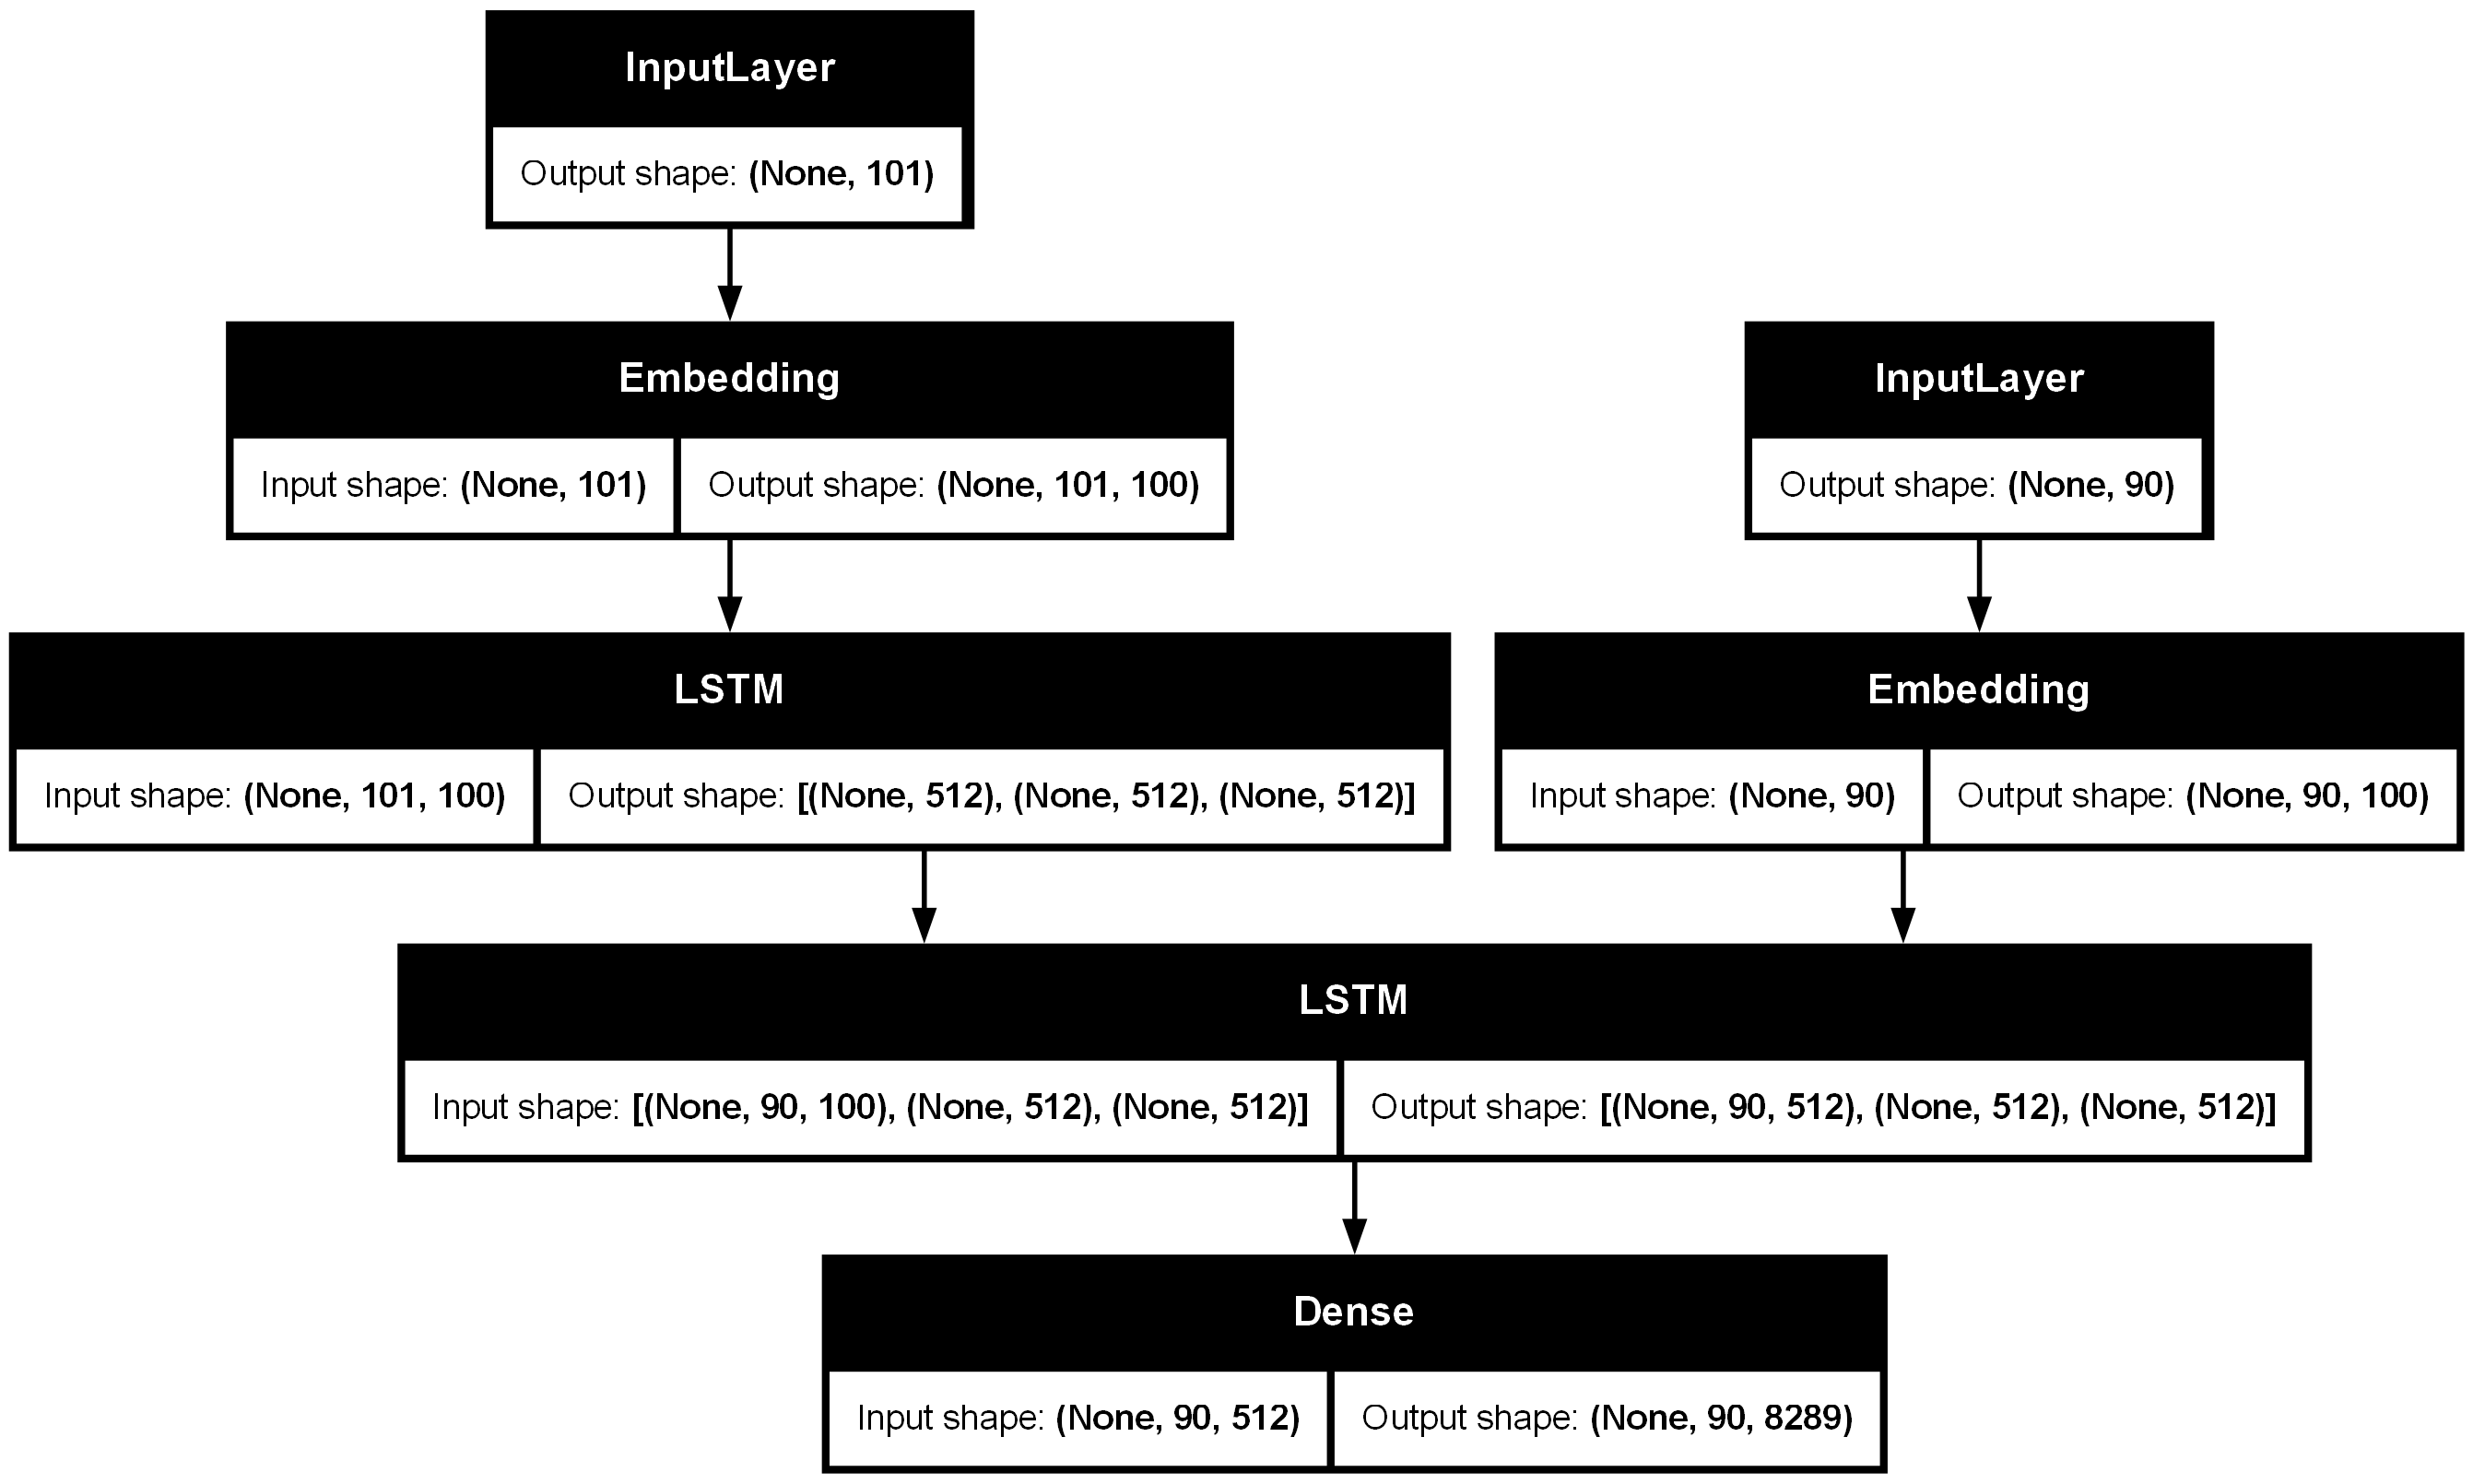

In [22]:
from tensorflow.keras.utils import plot_model    # keras 모델 구조를 이미지로 그려주는 유틸

plot_model(decoder_teacher_forcing_model, show_shapes=True)  # 레이어 연결도 + 각 레이어 출력 shape 표시

In [24]:
# Seq2Seq(Teacher Forcing) 모델 컴파일 및 학습
from tensorflow.keras.callbacks import CSVLogger    # 학습 로그를 CSV로 저장하는 콜백

csv_logger = CSVLogger("train_log.csv", append=True)  # 기존 파일이 있으면 이어서 기록

# 학습 설정 (손실, 옵티마이저, 평가지표)
decoder_teacher_forcing_model.compile(
    loss = 'sparse_categorical_crossentropy',  # 정답이 정수ID일때 쓰는 다중분류 손실
    optimizer = 'adam',
    metrics = ['accuracy']    # 토큰 단위 정확도 모니터링
)

# 모델 학습 진행
history = decoder_teacher_forcing_model.fit(
    [eng_inputs_padded, kor_inputs_padded],  # 입력 : 영어(인코더) + 한국어(<sos> 포함, 디코더 입력)
    kor_targets_padded,                      # 정답 : 한국어 타겟 (<eos> 포함) 시퀀스
    batch_size = 128,                        # 배치 크기
    epochs = 70,                             # 학습 반복 횟수
    validation_split = 0.2,                  # 검증 데이터 20% 사용
    callbacks=[csv_logger]                   # epoch마다 train_log.csv에 loss/acc 기록
)

Epoch 1/70


37/37 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.9491 - loss: 0.8267 - val_accuracy: 0.9199 - val_loss: 0.6878
Epoch 2/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9586 - loss: 0.3429 - val_accuracy: 0.9272 - val_loss: 0.6610
Epoch 3/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.9609 - loss: 0.3238 - val_accuracy: 0.9300 - val_loss: 0.6430
Epoch 4/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9610 - loss: 0.3149 - val_accuracy: 0.9307 - val_loss: 0.6373
Epoch 5/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9610 - loss: 0.3093 - val_accuracy: 0.9309 - val_loss: 0.6344
Epoch 6/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9610 - loss: 0.3042 - val_accuracy: 0.9309 - val_loss: 0.6307
Epoch 7/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9611 - loss: 0.2996 - val_accuracy: 0.9311 - val_loss: 0.6331
Epoch 8/70
37/37 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9611 - loss: 0.2943 - val_accuracy: 0.9311 - val_loss: 0.6424
Ep

KeyboardInterrupt: 

In [ ]:
# 학습 로그(history) 시각화 (loss/accuracy 곡선) : 전체를 다 학습완료시 시각화
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()  # hisotry(loss/acc/val_loss/val_acc)를 DataFrame으로 만들어 선 그래프 표시
plt.show()

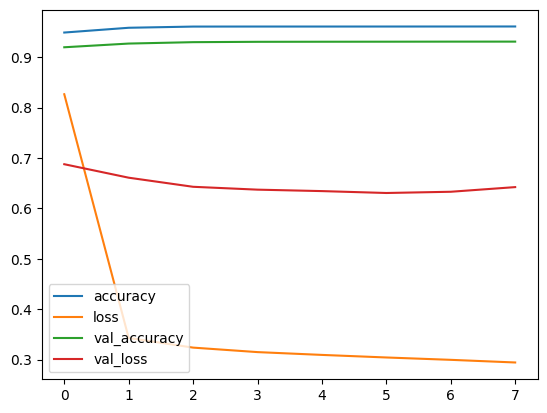

In [25]:
#  학습 로그(CSV 로그) 시각화 (loss/accuracy 곡선) : 중간에 끊었을 때 시각화
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("train_log.csv")
df = df.drop(columns=['epoch']).plot()
plt.show()

In [26]:
# Seq2Seq (Teacher Forcing) 모델 저장 (.keras 포맷)
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')

In [27]:
# 저장된 Seq2Seq (Teacher Forcing) 모델 로드
from tensorflow.keras.models import load_model    # 저장된 keras 모델을 불러오는 함수
decoder_teacher_forcing_model = load_model('decoder_teacher_forcing_model.keras')

load_model을 사용해서 저장 당시의 모델 구조와 가중치가 복원되어 바로 predict()하거나 추가학습에 사용할 수 있습니다.

### 모델 추론

`encoder + decoder(inference)` 구조의 모델로 추론

##### 디코더 추론 모델

In [28]:
# Seq2Seq Decoder 추론용 모델 구성
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))    # 이전 시점 hidden state(h) 입력
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))      # 이전 시점 cell state(c) 입력
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]  # (h, c) 상태 입력 묶음

decoder_single_input = layers.Input(shape=(1,))  # 추론시 1개 토큰(ID)만 입력 (한 스텝 디코딩)

x = ko_embedding_layer(decoder_single_input)     # (배치, 1) -> (배치, 1, EMBEDDING_DIM) 임베딩



x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)  # 입력 토큰 + 이전 상태(h, c)로 다음 상태 계산
decoder_states = [h, c]                          # 다음 스텝에 넘길 상태 (h, c) 저장

decoder_outputs_ = decoder_dense(x)              # (배치, 1, kor_num_words+1) 다음 단어 확률 분포 출록

# 추론용 디코더 모델 정의 (한 스텝)
decoder_inference_model = models.Model(
    inputs = [decoder_single_input] + decoder_states_inputs,  # 입력 : 현재 토큰 + 이전상태(h, c)
    outputs = [decoder_outputs_] + decoder_states            # 단어 분포 + 다음 상태(h, c)
)

decoder_inference_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │    828,900 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_1[1][0… │
│                     │ (None, 512),      │            │ input_layer_2[0]… │
│                     │ (None, 512)]      │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 8289)   │  4,252,257 │ lstm_1[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,336,581 (24.17 MB)

 Trainable params: 6,336,581 (24.17 MB)

 Non-trainable params: 0 (0.00 B)

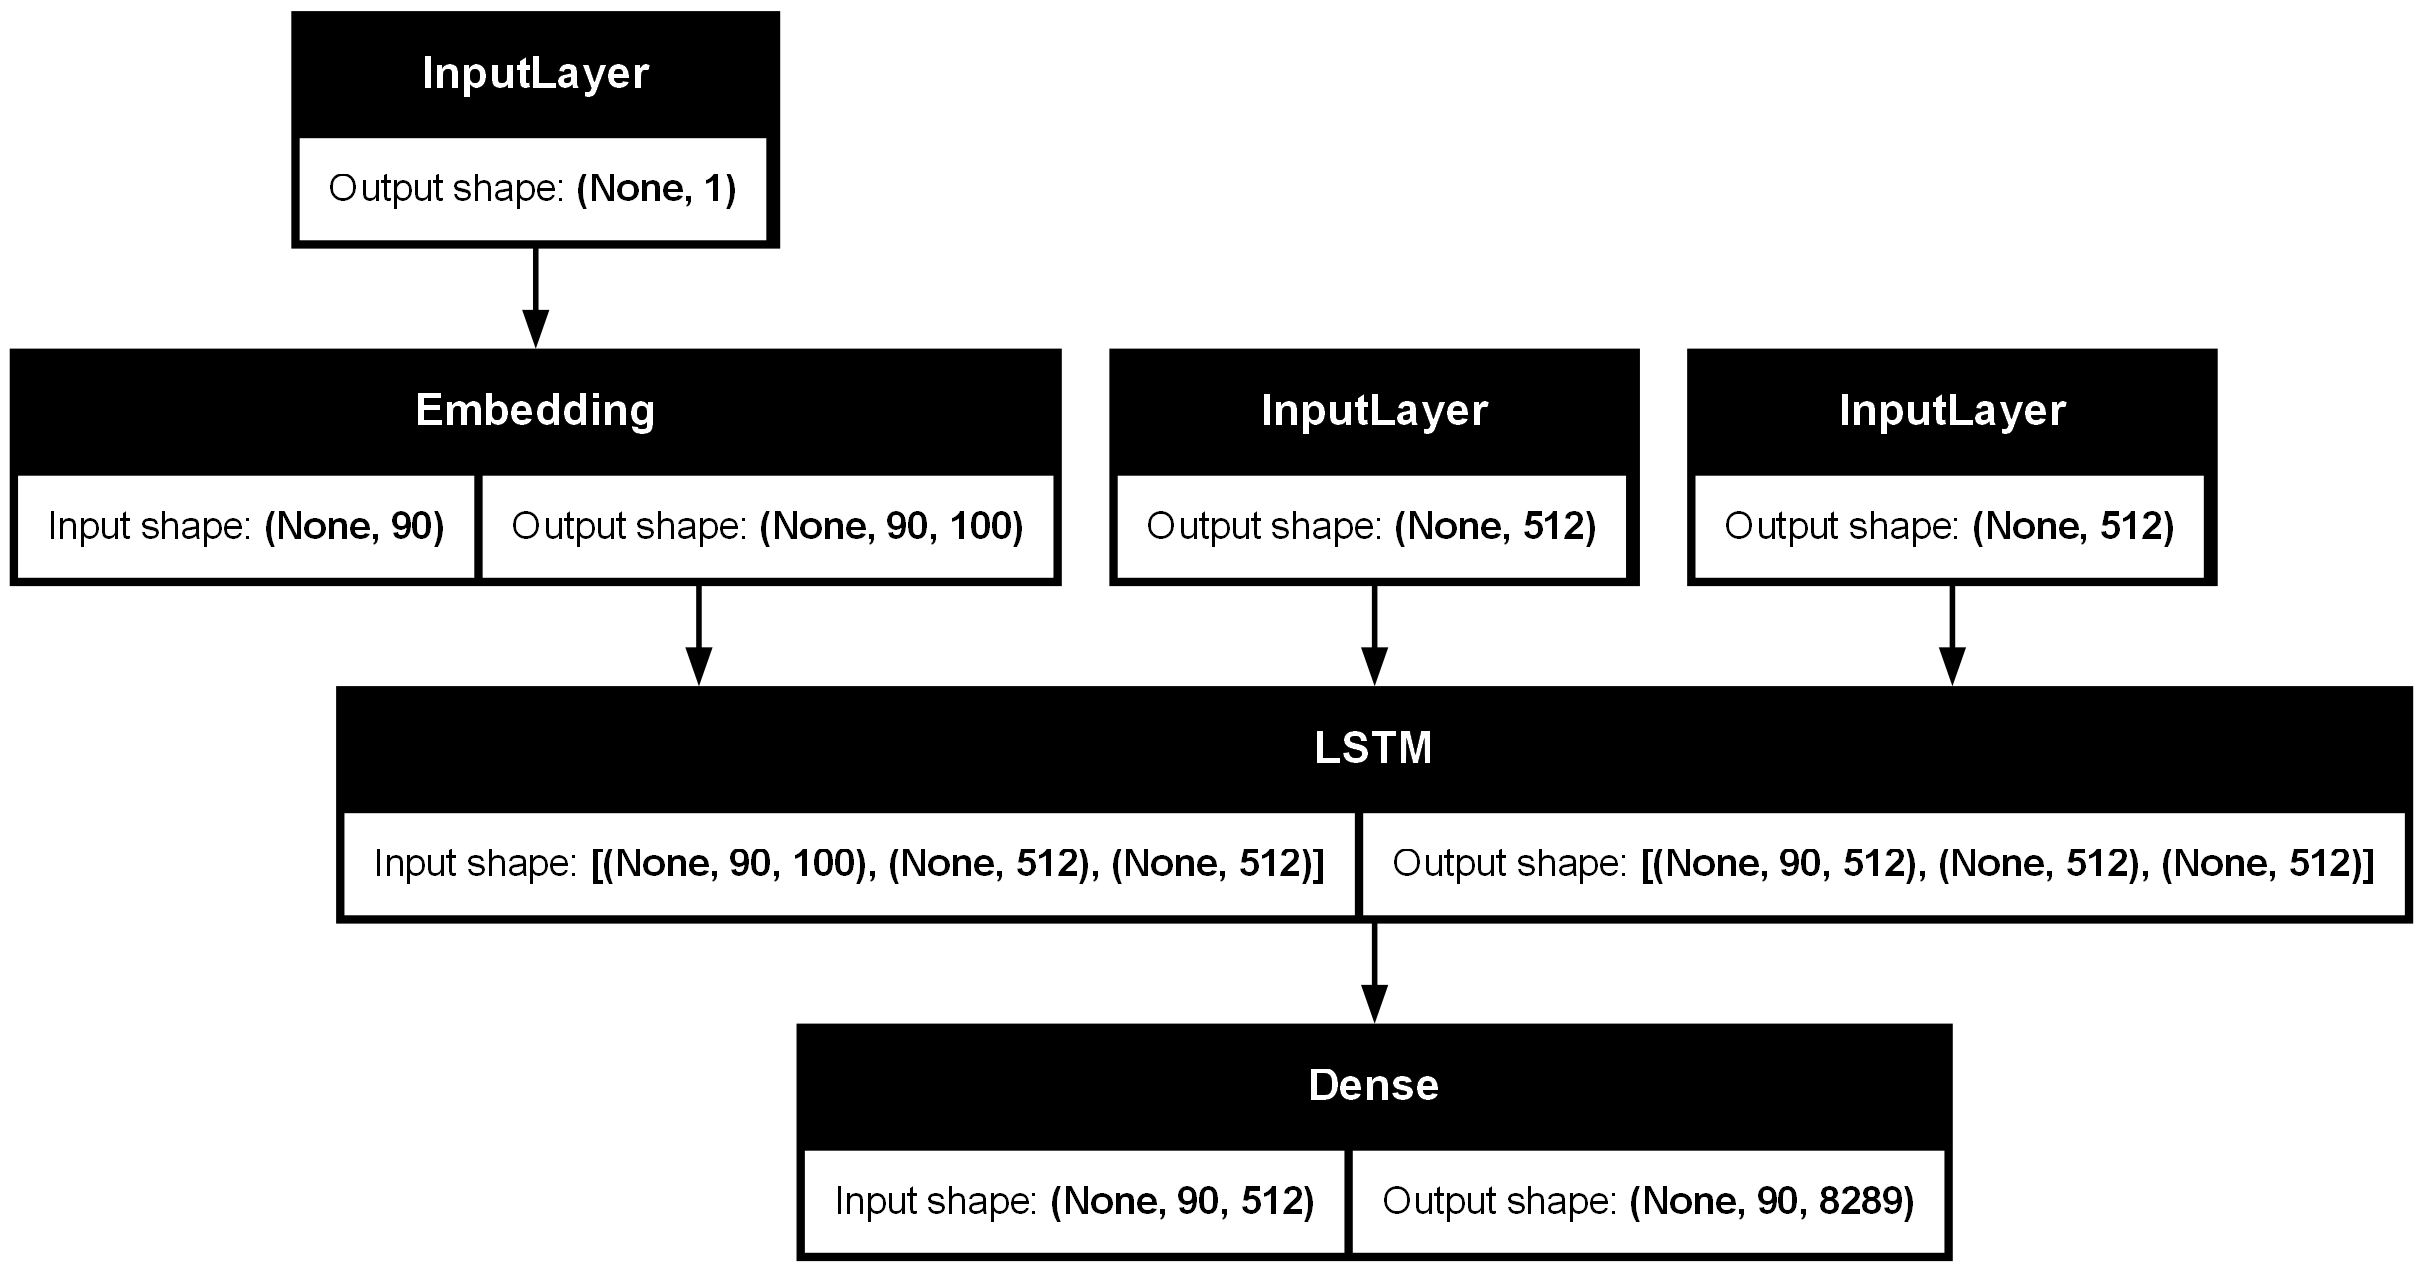

In [29]:
plot_model(decoder_inference_model, show_shapes=True)

##### 추론 함수

In [30]:
# Seq2Seq 번역 함수 (Encoder-Decoder 추론 루프)
# 입력 영어 시퀀스를 인코더로 state 변환한 후, <sos>부터 시작해 한 단어씩 생성하는 번역 함수
def translate(input_seq):
    encoder_states_value = encoder_model.predict(input_seq)  # 인코더로부터 초기 상태 (h, c) 추출
    decoder_states_value = encoder_states_value              # 디코더 초기 상태를 인코더 상태로 설정

    sos_index = kor_tokenizer.word_index['<sos>']  # 시작 토큰(<sos>)의 ID
    eos_index = kor_tokenizer.word_index['<eos>']  # 종료 토큰(<eos>)의 ID

    target_seq = np.zeros((1, 1))    # 디코더 입력(현재 토큰) 자리 (배치1, 길이1)
    target_seq[0, 0] = sos_index     # 첫 입력 토큰은 <sos> 토큰

    output_sentence = []             # 생성된 단어(토큰)들을 담을 리스트

    for _ in range(kor_max_len):
        # (현재 토큰 + 이전 state)로 다음 토큰 분포와 state 예측
        output_tokens, h, c = decoder_inference_model.predict(
            [target_seq] + decoder_states_value
        )

        pred_proba = output_tokens[0, 0, :]  # (1, 1, V) -> (V, )로 확률 벡터 추출
        pred_index = np.argmax(pred_proba)   # 가장 확률이 큰 단어 ID 선택 (Greedy decoding)

        if pred_index == eos_index:          # eos가 나오면 문장 생성 종료
            break

        if pred_index > 0:                   # pad 인덱스가 아니면
            word = kor_tokenizer.index_word[pred_index]    # 예측 ID -> 단어로 역변환
            output_sentence.append(word)
        
        target_seq[0, 0] = pred_index    # 다음 스텝 입력 토큰을 이번 예측 토큰으로 갱신
        decoder_states_value = [h, c]    # 다음 스텝에 사용할 state(h, c) 갱신

    return " ".join(output_sentence)

### 테스트

In [32]:
# 번역 입력 확인 및 1개 샘플 번역
print(eng_inputs[:1])     # 원본 영어 문장 첫 1개 확인

input_seq = eng_inputs_padded[:1]  # 첫 1개 영어 문장을 패딩된 시퀀스로 준비 (Batch 1)
translate(input_seq)

['Go.']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


''

In [33]:
# 랜덤 샘플 5개 번역 비교 출력
for _ in range(5):
    idx = np.random.choice(len(eng_inputs_padded))  # 전체 데이터 인덱스 중 하나를 무작위 선택
    input_seq = eng_inputs_padded[idx:idx+1]        # 선택된 1개 문장을 배치 형태(1개)로 준비
    output_sent = translate(input_seq)              # 추론 번역
    display("입력 영문 :", eng_inputs[idx])          # 원본 영어 문장
    display("학습된 국문 :", kor_inputs[idx])        # 학습용 한국어
    display("추론한 국문 :", output_sent)            # 모델이 생성한 한국어 번역

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'입력 영문 :'

'Do you like singing?'

'학습된 국문 :'

'<sos> 노래하는 거 좋아해요?'

'추론한 국문 :'

'톰은'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'입력 영문 :'

"Tom could've been seriously injured."

'학습된 국문 :'

'<sos> 톰은 심각한 부상을 당할 수도 있었다.'

'추론한 국문 :'

'톰은 내'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'입력 영문 :'

'This is my school.'

'학습된 국문 :'

'<sos> 이곳은 내 학교다.'

'추론한 국문 :'

'톰은'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'입력 영문 :'

'Social media is a waste of time.'

'학습된 국문 :'

'<sos> 소셜 미디어는 시간 낭비야.'

'추론한 국문 :'

'톰은 내'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'입력 영문 :'

"I'm really sorry."

'학습된 국문 :'

'<sos> 정말 미안해.'

'추론한 국문 :'

'톰은'

In [34]:
# 영어 문장을 입력하면 한국어로 번역하는 래퍼함수
def translate_eng2kor(eng_text):
    input_seq = eng_tokenizer.texts_to_sequences(eng_text)    # 영어 문장(리스트)을 단어 ID 시퀀스로 변환
    input_seq = pad_sequences(input_seq, maxlen=eng_max_len)  # 인코더 입력 길이에 맞게 패딩 처리
    return translate(input_seq)    # 추론 함수로 번역 결과 반환

eng_texts = [
    "My hair is black.",
    "French is interesting.",
    "I like bus.",
    "Let\'s study",
    "I ate sandwich"
]

for eng_text in eng_texts:
    kor_text = translate_eng2kor([eng_text])  # 배치 형태로 넣기 위해 리스트로 감싸서 전달
    display(eng_text, kor_text)               # 원문 영어와 번역 결과를 함께 표시

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'My hair is black.'

'톰은 내'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'French is interesting.'

'톰은'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'I like bus.'

'톰은'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


"Let's study"

'톰은'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


'I ate sandwich'

'톰은'